In [1]:
import tensorflow as tf
import keras
import os, re, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, MaxPool2D, Flatten, Dense, Activation, Conv2DTranspose, Concatenate, UpSampling2D, merge, Convolution2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.ndimage.morphology import distance_transform_edt as edt
from IPython.display import clear_output
import datetime

In [2]:
%load_ext tensorboard

In [3]:
# Install a Drive FUSE wrapper.
 # https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse      

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [4]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [5]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [6]:
# Create a directory and mount Google Drive using that directory.

!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
imgs = np.load('drive/ISIC-Data/imgs.npy')
labels = np.load('drive/ISIC-Data/labels.npy')
test_imgs = np.load('drive/ISIC-Data/test_imgs.npy')
test_labels = np.load('drive/ISIC-Data/test_labels.npy')

In [70]:
def plotImages(images_arr, title):
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.squeeze(), cmap='Greys_r')
    plt.suptitle(title, y=0.7, fontsize=16)
    plt.tight_layout()
    plt.show()

In [9]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.2, random_state=0)

In [10]:
x_train /= 255.
y_train /= 255.
x_val /= 255.
y_val /= 255.
test_imgs /= 255.
test_labels /= 255.

In [11]:
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(x_train, y_train, test_size=0.625, random_state=0)

In [12]:
def call(self, inputs, training=None):
  if 0. < self.rate < 1.:
      noise_shape = self._get_noise_shape(inputs)
      def dropped_inputs():
          return K.dropout(inputs, self.rate, noise_shape,
                            seed=self.seed)
      if (training):
          return K.in_train_phase(dropped_inputs, inputs, training=training)
      else:
          return K.in_test_phase(dropped_inputs, inputs, training=None)
  return inputs

In [13]:
Dropout.call = call

In [14]:
def create_unet():
  input = Input(shape=(256,256,1))

  down1 = Conv2D(64, (3,3), padding='same')(input)
  down1 = Activation('relu')(down1)
  down1 = Dropout(0.1)(down1)
  down1 = Conv2D(64, (3,3), padding='same')(down1)
  down1 = Activation('relu')(down1)

  down2 = MaxPool2D()(down1)
  down2 = Conv2D(128, (3,3), padding='same')(down2)
  down2 = Activation('relu')(down2)
  down2 = Dropout(0.1)(down2)
  down2 = Conv2D(128, (3,3), padding='same')(down2)
  down2 = Activation('relu')(down2)

  down3 = MaxPool2D()(down2)
  down3 = Conv2D(256, (3,3), padding='same')(down3)
  down3 = Activation('relu')(down3)
  down3 = Dropout(0.2)(down3)
  down3 = Conv2D(256, (3,3), padding='same')(down3)
  down3 = Activation('relu')(down3)

  down4 = MaxPool2D()(down3)
  down4 = Conv2D(512, (3,3), padding='same')(down4)
  down4 = Activation('relu')(down4)
  down4 = Dropout(0.2)(down4)
  down4 = Conv2D(512, (3,3), padding='same')(down4)
  down4 = Activation('relu')(down4)

  down5 = MaxPool2D()(down4)
  down5 = Conv2D(1024, (3,3), padding='same')(down5)
  down5 = Activation('relu')(down5)
  
  down5 = Conv2D(1024, (3,3), padding='same')(down5)
  down5 = Activation('relu')(down5)

  down5 = Dropout(0.4)(down5)
  
  up1 = Conv2DTranspose(512, (2,2), strides=(2,2))(down5)
  up1 = Concatenate()([up1,down4])
  up1 = Conv2D(512, (3,3), padding='same')(up1)
  up1 = Activation('relu')(up1)
  up1 = Dropout(0.2)(up1)
  up1 = Conv2D(512, (3,3), padding='same')(up1)
  up1 = Activation('relu')(up1)

  up2 = Conv2DTranspose(256, (2,2), strides=(2,2))(up1)
  up2 = Concatenate()([up2,down3])
  up2 = Conv2D(256, (3,3), padding='same')(up2)
  up2 = Activation('relu')(up2)
  up2 = Dropout(0.2)(up2)
  up2 = Conv2D(256, (3,3), padding='same')(up2)
  up2 = Activation('relu')(up2)

  up3 = Conv2DTranspose(128, (2,2), strides=(2,2))(up2)
  up3 = Concatenate()([up3,down2])
  up3 = Conv2D(128, (3,3), padding='same')(up3)
  up3 = Activation('relu')(up3)
  up3 = Dropout(0.1)(up3)
  up3 = Conv2D(128, (3,3), padding='same')(up3)
  up3 = Activation('relu')(up3)

  up4 = Conv2DTranspose(64, (2,2), strides=(2,2))(up3)
  up4 = Concatenate()([up4,down1])
  up4 = Conv2D(64, (3,3), padding='same')(up4)
  up4 = Activation('relu')(up4)
  up4 = Dropout(0.1)(up4)
  up4 = Conv2D(64, (3,3), padding='same')(up4)
  up4 = Activation('relu')(up4)

  output = Conv2D(1, (1,1), activation='sigmoid')(up4)

  model =  Model(input, output)

  opt = Adam(learning_rate=1e-5)
  model.compile(optimizer=opt,loss=dice_coef_loss, metrics=[dice_coef])

  return model

In [15]:
def dice_coef(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [17]:
def range_transform(sample):
  if (np.max(sample) == 1):
      sample = sample * 255

  m = 255 / (np.max(sample) - np.min(sample))
  n = 255 - m * np.max(sample)
  return (m * sample + n) / 255

In [18]:
def no_detections_index(uncertainity, nb_no_detections=10):
  return np.argsort(uncertainity)[0:nb_no_detections]

In [19]:
def most_uncertain_index(uncertainity, nb_most_unceratin=10):
  s_uncertainity = np.argsort(uncertainity)
  return s_uncertainity[::-1][0:nb_most_unceratin]

In [20]:
def interval(data, start, end):
  p = np.where(data >= start)[0]
  return p[np.where(data[p] < end)[0]]

In [21]:
def compute_uncertainity(x_unlabeled, best_model):
  
  uncertainity = []
  # edt_uncertainity = []
  uncertainity_map = []
  i = 1
  n = len(x_unlabeled)
  for sample in x_unlabeled:
    sample = sample.reshape([1,256,256,1])
    all_step_predictions = np.zeros([256,256,1])
    for t in range(10):
      step_prediction = best_model.predict(sample).reshape([256,256,1])
      all_step_predictions = np.concatenate((all_step_predictions, step_prediction), axis=2)
    all_step_predictions = np.delete(all_step_predictions, [0], 2)
    # transform = range_transform(edt(step_prediction))
    var = np.var(all_step_predictions, axis=2)
    uncertainity_map.append(var.reshape(256,256,1))
    uncertain = np.sum(var)
    uncertainity.append(uncertain)
    # edt_uncertainity.append(np.sum(var * transform))

    clear_output(wait=True)
    print("Computing Uncertainty" + "."*((i%3)+1))
    print(str(i) + '/' + str(n) + ' images.')
    i = i+1

  return np.array(uncertainity), np.array(uncertainity_map)

In [22]:
def train(x_labeled, y_labeled, model, tensorboard_callback, epochs):
  
  checkpoint = ModelCheckpoint("initial_weights.h5", monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
  early = EarlyStopping(monitor='val_dice_coef', min_delta=0.01, patience=10, verbose=1, mode='max')

  results = model.fit(x_labeled, y_labeled, epochs = epochs, batch_size=16, validation_data=(x_val, y_val), callbacks=[early,checkpoint,tensorboard_callback])

In [23]:
def label_data(x_labeled, x_unlabeled, y_labeled, y_unlabeled, iteration):

  best_model = create_unet()
  best_model.load_weights('initial_weights.h5')
  predictions = best_model.predict(x_unlabeled)

  uncertainity, uncertainity_map = compute_uncertainity(x_unlabeled, best_model)

  histo = np.histogram(uncertainity, 100)

  # Oracle Indices
  not_detected = no_detections_index(uncertainity)
  most_uncertain = most_uncertain_index(uncertainity)

  oracle_i = interval(uncertainity, histo[1][np.argmax(histo[0]) + 6], histo[1][len(histo[0]) - 33])
  np.random.shuffle(oracle_i)
  random_index = oracle_i[:15]

  oracle_indices = np.concatenate((random_index, not_detected, most_uncertain))

  # Pseudo Indices
  nb_pseudo_indices = 20 * iteration
  pseudo_indices = interval(uncertainity, histo[1][np.argmax(histo[0])], histo[1][np.argmax(histo[0])+1])[:nb_pseudo_indices]

  pseudo_dice = [compute_dice_coef(y_unlabeled[x],predictions[x]) for x in pseudo_indices]
  print(np.average(pseudo_dice))

  # Update Labeled Data
  x_labeled = np.concatenate((x_labeled, x_unlabeled[pseudo_indices], x_unlabeled[oracle_indices]))
  x_unlabeled = np.delete(x_unlabeled, pseudo_indices, 0)
  x_unlabeled = np.delete(x_unlabeled, oracle_indices, 0)

  y_labeled = np.concatenate((y_labeled, predictions[pseudo_indices], y_unlabeled[oracle_indices]))
  y_unlabeled = np.delete(y_unlabeled, pseudo_indices, 0)
  y_unlabeled = np.delete(y_unlabeled, oracle_indices, 0)

  return x_labeled, x_unlabeled, y_labeled, y_unlabeled, uncertainity_map

In [24]:
def compute_dice_coef(y_true, y_pred):
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, 256 * 256])
    y_pred_f = y_pred.reshape([1, 256 * 256])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# **Initial Training**

In [25]:
log_dir="logs/initialTrain/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
model = create_unet()
train(x_labeled, y_labeled, model, tensorboard_callback, epochs=20)

Epoch 1/20
 1/38 [..............................] - ETA: 0s - loss: 0.6935 - dice_coef: 0.3065WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - ETA: 0s - loss: 0.7205 - dice_coef: 0.2796WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0054s vs `on_test_batch_end` time: 0.2466s). Check your callbacks.

Epoch 00001: val_dice_coef improved from -inf to 0.27035, saving model to initial_weights.h5
38/38 [==============================] - 39s 1s/step - loss: 0.7205 - dice_coef: 0.2796 - val_loss: 0.7297 - val_dice_coef: 0.2703
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.7212 - dice_coef: 0.2761
Epoch 00002: val_dice_coef improved from 0.27035 to 

# **Active Learning**

In [27]:
uncertainity_maps = []
for i in range(10):

  x_labeled, x_unlabeled, y_labeled, y_unlabeled, uncertainity_map = label_data(x_labeled, x_unlabeled, y_labeled, y_unlabeled, i+1)
  uncertainity_maps.append(uncertainity_map)

  model = create_unet()
  model.load_weights('initial_weights.h5')

  log_dir="logs/active_iteration_" + str(i+1) + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  train(x_labeled, y_labeled, model, tensorboard_callback, epochs=5)

Computing Uncertainty..
346/346 images.
0.8538113603697767
Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.1843 - dice_coef: 0.8161WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0433s vs `on_test_batch_end` time: 0.2226s). Check your callbacks.

Epoch 00001: val_dice_coef improved from -inf to 0.85177, saving model to initial_weights.h5
83/83 [==============================] - 76s 917ms/step - loss: 0.1843 - dice_coef: 0.8161 - val_loss: 0.1482 - val_dice_coef: 0.8518
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1808 - dice_coef: 0.8188
Epoch 00002: val_dice_coef did not improve from 0.85177
83/83 [==============================] - 74s 894ms/step - loss: 0.1808 - dice_coef: 0.8188 - val_loss: 0.1546 - val_dice_coef: 0.8454
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1812 - dice_coef: 0.8185
Epoch 00003: val_dice_coef did not improve from 0.85177
83/83 [======

In [29]:
!tensorboard dev upload --logdir ./logs \
  --name "Active Learning for Melanoma Segmentation" \
  --description "Training results from https://colab.research.google.com/drive/1hmBWmZ-_WzK5CA9dO4s8x2DwriGoXxl7?usp=sharing" \
  --one_shot

2020-12-06 20:12:46.491587: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

In [32]:
best_model = create_unet()
best_model.load_weights('initial_weights.h5')

In [33]:
predict = best_model.predict(test_imgs, verbose=1)

19/19 [==============================] - 10s 534ms/step


In [73]:
test_dice = [compute_dice_coef(test_labels[x],predict[x]) for x in range(len(predict))]

In [74]:
np.average(test_dice), np.median(test_dice), np.min(test_dice), np.max(test_dice)

(0.7426766527396109,
 0.8300632963546932,
 9.6915402377609e-05,
 0.9759332570539568)

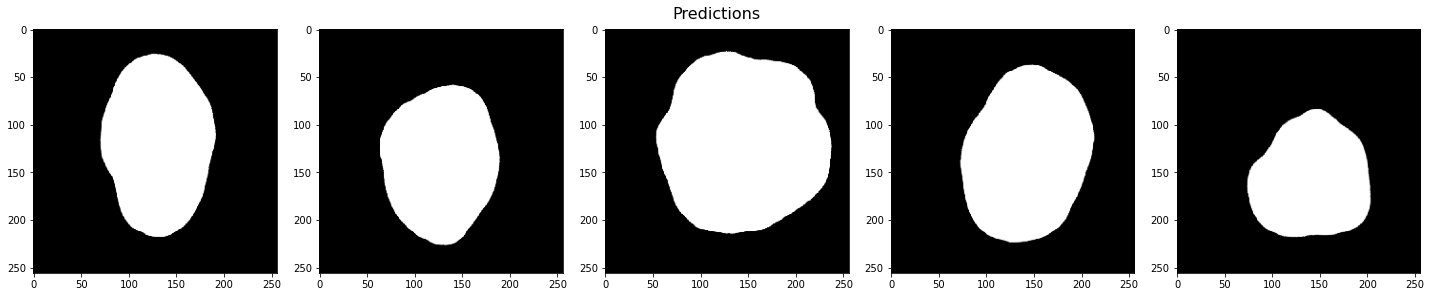

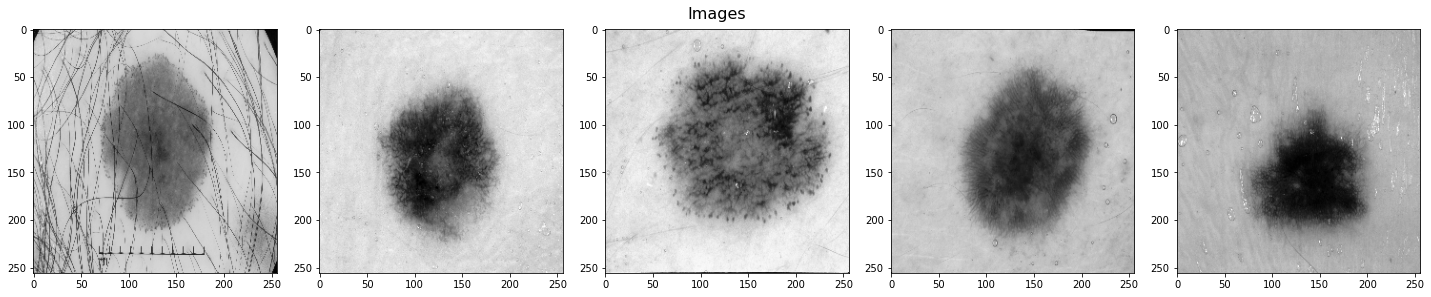

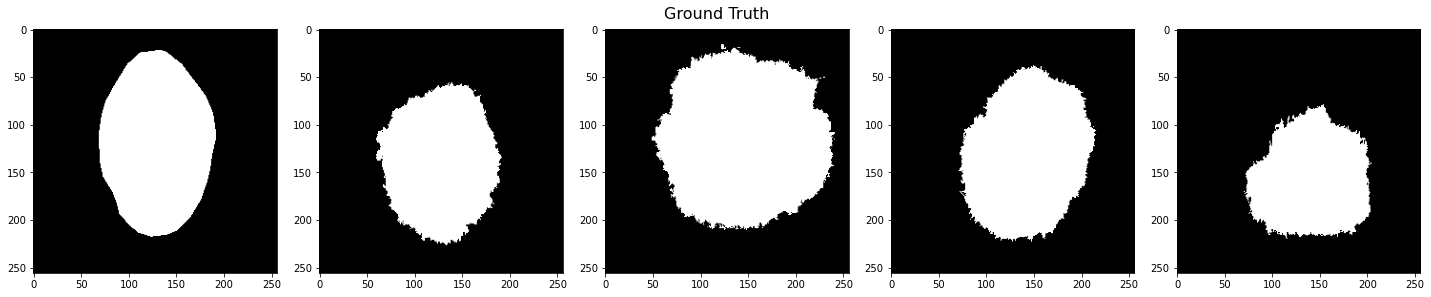

In [72]:
plotImages(predict[np.argsort(test_dice)[::-1]], 'Predictions')
plotImages(test_imgs[np.argsort(test_dice)[::-1]], 'Images')
plotImages(test_labels[np.argsort(test_dice)[::-1]], 'Ground Truth')

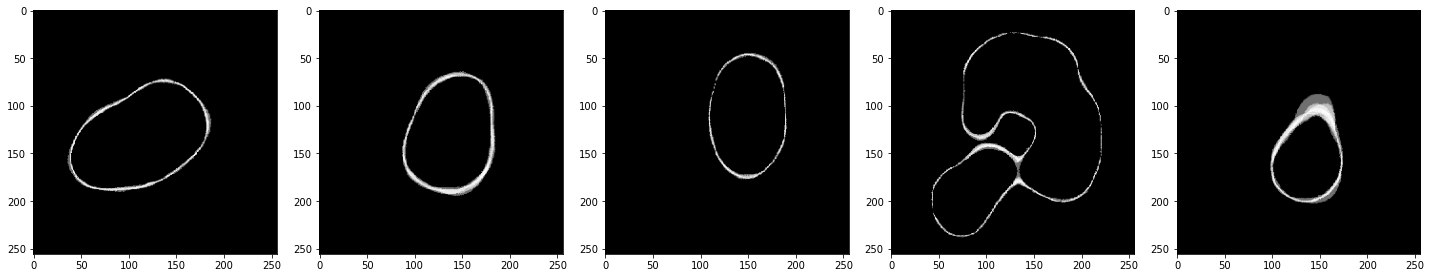

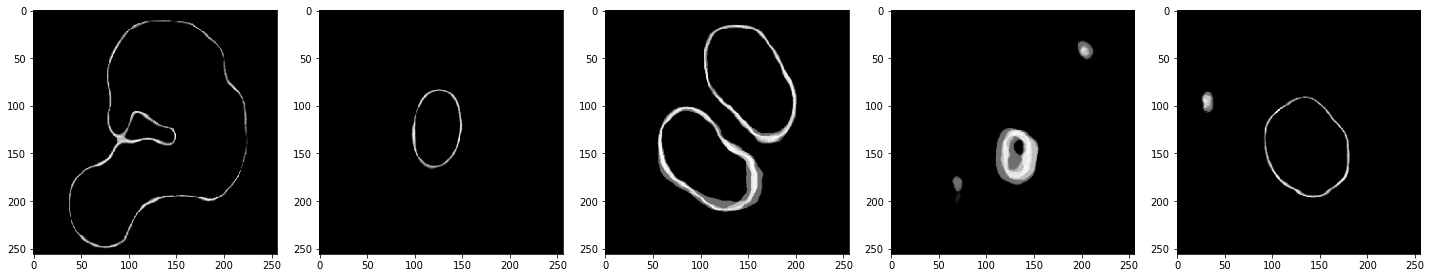

In [98]:
plotImages(np.sort(uncertainity_maps[0]), None)
plotImages(np.sort(uncertainity_maps[-1]), None)

In [75]:
uncertainity_maps[0].shape

(1000, 256, 256, 1)

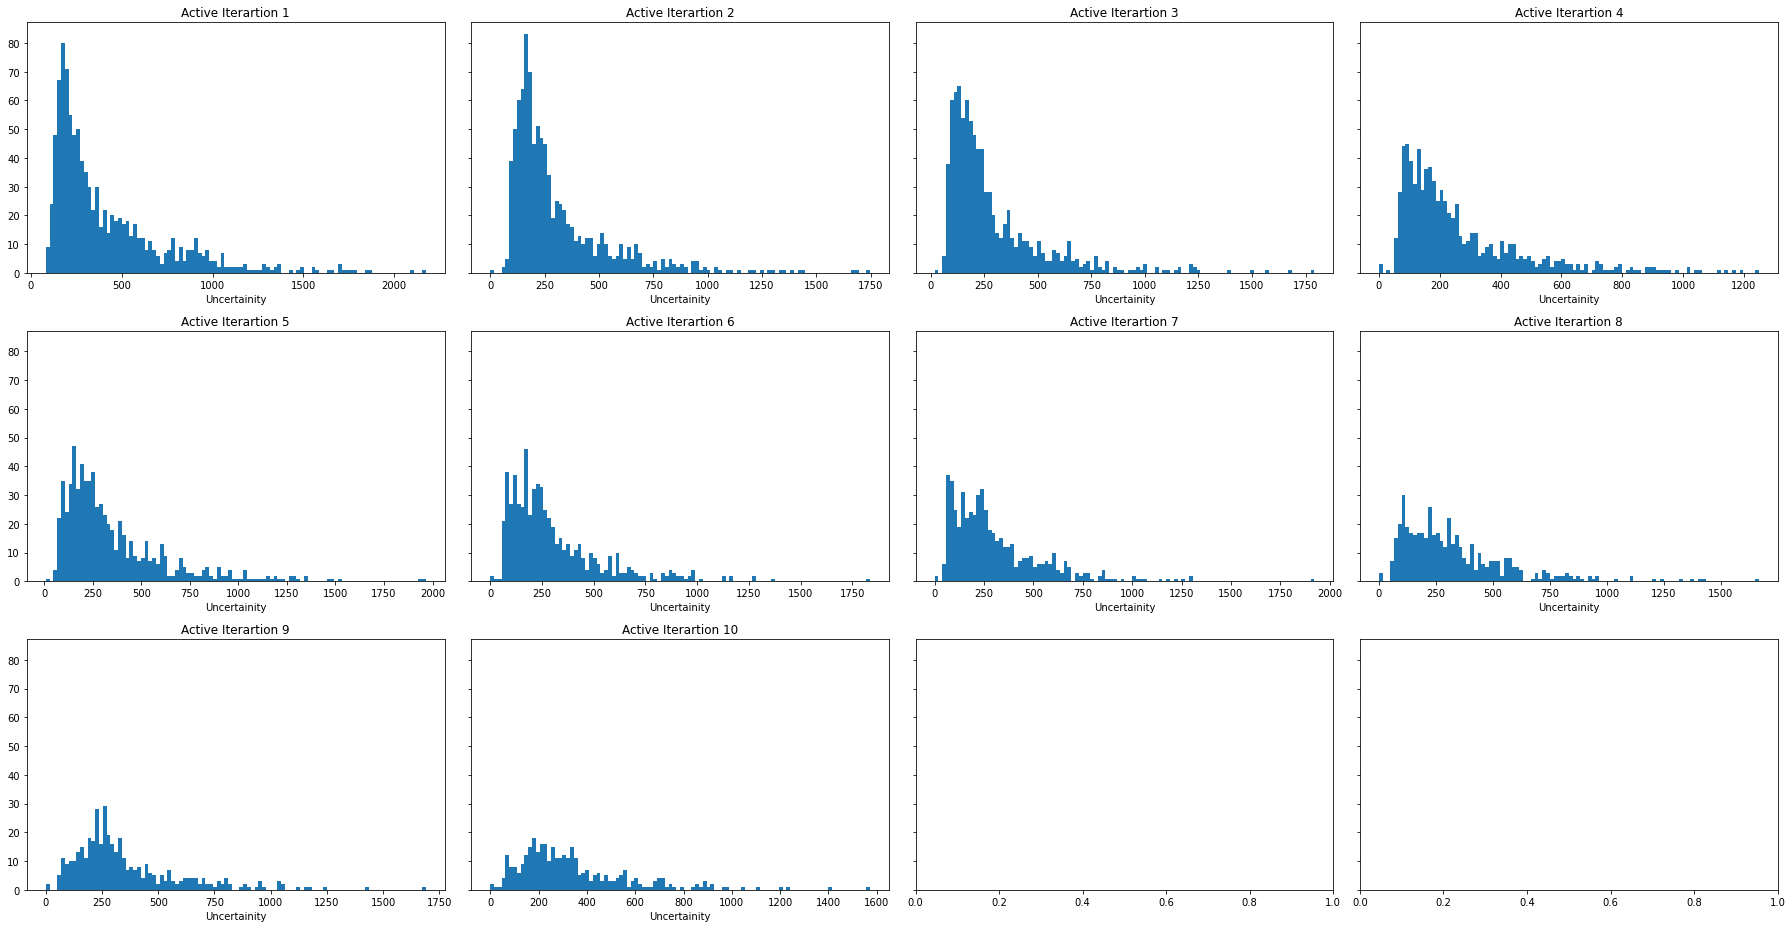

In [106]:
fig, ax = plt.subplots(3,4, sharey=True, tight_layout=True, figsize=(25,13))
axes = ax.flatten()
for i in range(len(uncertainity_maps)):
  n, bins, patches = axes[i].hist(np.sum(uncertainity_maps[i], axis=(1,2,3)), 100)
  axes[i].set_xlabel('Uncertainity')
  axes[i].set_title('Active Iterartion '+str(i+1))
plt.show()